In [1]:
# import necessary libraries for this calculation
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import scipy.io
from pathlib import Path
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import gsw
plt.rcParams['font.size']=14

In [2]:
# Sea Ice Satellite data
dso16=xr.open_mfdataset('/home/birte/observation/sea_ice/reduced_data/sic_20160[7,8]*.nc')
dso17=xr.open_mfdataset('/home/birte/observation/sea_ice/reduced_data/sic_201709*.nc')
dso=xr.merge((dso16,dso17))
dso.coords['year']=dso.time.dt.year
dso.coords['month']=dso.time.dt.month
dso.coords['day']=dso.time.dt.day
dso['sic']=dso.z

In [3]:
ds16=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/Maud12t_2016_icemod_grid_T.nc')
ds17=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/Maud12t_2017_icemod_grid_T.nc')
bat=xr.open_dataset('/home/birte//MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['lon']=bat.nav_lon
bat.coords['lat']=bat.nav_lat


bat['mask_tc']=np.zeros((len(bat.y),len(bat.x)))*(bat.bathy_meter.where(bat.bathy_meter<2500))+1
bat['mask_tc']=bat.mask_tc.where(((bat.mask_tc==1)&(bat.glamt<4.3)&(bat.glamt>0.5)&(bat.gphit>-65.5)),other=0)
mask_tc=bat.mask_tc
mask_tc.load()
mask_tc[173,98]=1
mask_tc[178,109]=0

bat['mask_tc']=mask_tc


In [4]:
# load the respective gridcell data
dsi_grid=xr.open_dataset('/home/birte/observation/sea_ice/NSIDC0771_LatLon_PS_S6.25km_v1.0.nc')
dsi_gridcell=xr.open_dataset('/home/birte/observation/sea_ice/PolStereo_GridCellArea_s6.25km_Antarctic.nc')
dsi=xr.merge((dsi_grid,dsi_gridcell))
dsi.coords['lon']=dsi.longitude
dsi.coords['lat']=dsi.latitude

dsi_grid=dsi.where((dsi.lon>-4)&(dsi.lon<19)&(dsi.lat>-67)&(dsi.lat<-62),drop=True)
dsi_grid=dsi_grid.rename_vars({'data':'area'})
year=2016
dso_a=xr.open_mfdataset(f'/home/birte/observation/sea_ice/reduced_data/sic_{year}*.nc')
dso_red= dso_a.where((dso_a.lon>-4)&(dso_a.lon<10)&(dso_a.lat>-67)&(dso_a.lat<-62),drop=True)
sic50=xr.where(dso_red.z<50,1,0)
sic10=xr.where(dso_red.z<10,1,0)
pa50=(sic50*dsi_grid.area*10**6).sum(dim={'x','y'})
pa10=(sic10*dsi_grid.area*10**6).sum(dim={'x','y'})

ds_dc= xr.Dataset(
    data_vars=dict(
              sic50 = (["time","y","x"], sic50.data),
              sic10 = (["time","y","x"], sic10.data),
              pa50 = (["time"], pa50.data),
              pa10 = (["time"], pa10.data)
              ),
    coords=dict(
              x=(["x"],dso_red.x.data),
              y=(["y"],dso_red.y.data),
              time=(["time"],dso_red.time.data)
              )
)

ds_dc = ds_dc.assign_coords({
     "lat": (["y", "x"],dso_red.lat.data),
     "lon": (["y", "x"],dso_red.lon.data)
})

ds_dc.to_netcdf(f'/home/birte/observation/sea_ice/polynya_area_{year}_sic.nc')

In [5]:
dso_pa=xr.open_mfdataset(f'/home/birte/observation/sea_ice/polynya_area_*_sic.nc')
dsm_pa=xr.open_mfdataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/polynya_area_20*_EXP_tpre02_prsn02_2012.nc')

In [6]:
time_array=np.array(dsm_pa.t,dtype=np.datetime64)

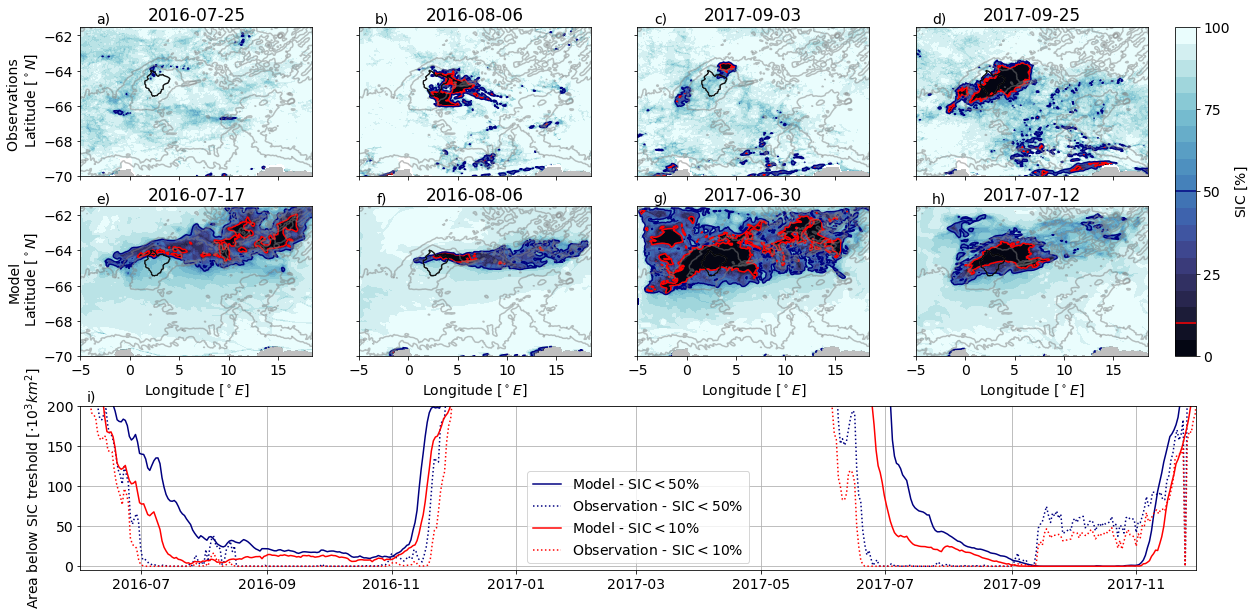

In [17]:
imap=cmo.ice
imin=0
imax=100
ilev=21
fig = plt.figure(figsize=(20,10))
gs = GridSpec(2,2, width_ratios=[1,0.02],height_ratios=[1,0.5],wspace=.05
             )#,hspace=.1)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(2,4, subplot_spec=gs[0,0], height_ratios=[1,1])
gs2 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1], height_ratios=[1])
gs3 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,:], height_ratios=[1])
obs16 = fig.add_subplot(gs1[0,0])
mod16 = fig.add_subplot(gs1[1,0])
obs162 = fig.add_subplot(gs1[0,1])#,sharey=ttc_m12)
mod162 = fig.add_subplot(gs1[1,1])
obs17 = fig.add_subplot(gs1[0,2])
mod17 = fig.add_subplot(gs1[1,2])
obs172 = fig.add_subplot(gs1[0,3])#,sharey=ttc_m12)
mod172 = fig.add_subplot(gs1[1,3])
c_ax = fig.add_subplot(gs2[0])
ts_paax = fig.add_subplot(gs3[0])

dso.sic.where((dso.year==2016)&(dso.month==7)&(dso.day==25),drop=True).isel(time=0).plot.contourf(x="lon",y="lat",ax=obs16,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
dso.sic.where((dso.year==2016)&(dso.month==7)&(dso.day==25),drop=True).isel(time=0).plot.contour(x="lon",y="lat",ax=obs16,levels=[10,50],colors=['r','navy'])

(ds16.siconc*100).isel(time_counter=198).plot.contourf(x="nav_lon",y="nav_lat",ax=mod16,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
(ds16.siconc*100).isel(time_counter=198).plot.contour(x="nav_lon",y="nav_lat",ax=mod16,levels=[10,50],colors=['r','navy'])

dso.sic.where((dso.year==2016)&(dso.month==8)&(dso.day==6),drop=True).isel(time=0).plot.contourf(x="lon",y="lat",ax=obs162,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
dso.sic.where((dso.year==2016)&(dso.month==8)&(dso.day==6),drop=True).isel(time=0).plot.contour(x="lon",y="lat",ax=obs162,levels=[10,50],colors=['r','navy'])

(ds16.siconc*100).isel(time_counter=218).plot.contourf(x="nav_lon",y="nav_lat",ax=mod162,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
(ds16.siconc*100).isel(time_counter=218).plot.contour(x="nav_lon",y="nav_lat",ax=mod162,levels=[10,50],colors=['r','navy'])

dso.sic.where((dso.year==2017)&(dso.month==9)&(dso.day==3),drop=True).isel(time=0).plot.contourf(x="lon",y="lat",ax=obs17,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
dso.sic.where((dso.year==2017)&(dso.month==9)&(dso.day==3),drop=True).isel(time=0).plot.contour(x="lon",y="lat",ax=obs17,levels=[10,50],colors=['r','navy'])

(ds17.siconc*100).isel(time_counter=180).plot.contourf(x="nav_lon",y="nav_lat",ax=mod17,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
(ds17.siconc*100).isel(time_counter=180).plot.contour(x="nav_lon",y="nav_lat",ax=mod17,levels=[10,50],colors=['r','navy'])

dso.sic.where((dso.year==2017)&(dso.month==9)&(dso.day==25),drop=True).isel(time=0).plot.contourf(x="lon",y="lat",ax=obs172,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
dso.sic.where((dso.year==2017)&(dso.month==9)&(dso.day==25),drop=True).isel(time=0).plot.contour(x="lon",y="lat",ax=obs172,levels=[10,50],colors=['r','navy'])

cice=(ds17.siconc*100).isel(time_counter=192).plot.contourf(x="nav_lon",y="nav_lat",ax=mod172,cmap=imap,vmin=imin,vmax=imax,levels=ilev,add_colorbar=False)
ccice=(ds17.siconc*100).isel(time_counter=192).plot.contour(x="nav_lon",y="nav_lat",ax=mod172,levels=[10,50],colors=['r','navy'])

cbar=plt.colorbar(cice,cax=c_ax,orientation="vertical",label='SIC [$\%$]',ticks=np.arange(0,125,25))
cbar.add_lines(ccice)

bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=obs16,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=obs16,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=obs17,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=obs17,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=mod16,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=mod16,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=mod17,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=mod17,alpha=0.5)

bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=obs162,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=obs162,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=obs172,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=obs172,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=mod162,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=mod162,alpha=0.5)
bat.bathy_meter.where(bat.bathy_meter<10).plot.contourf(x="lon",y="lat",colors='grey',add_colorbar=False,ax=mod172,alpha=0.5)
bat.bathy_meter.plot.contour(x="lon",y="lat",levels=[2500,3500,5000],colors='grey',ax=mod172,alpha=0.5)


bat.mask_tc.plot.contour(x="lon",y="lat",ax=obs16,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=obs17,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=obs162,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=obs172,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=mod16,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=mod162,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=mod17,colors='k',linestyles='-',linewidths=.7,alpha=.5)
bat.mask_tc.plot.contour(x="lon",y="lat",ax=mod172,colors='k',linestyles='-',linewidths=.7,alpha=.5)

obs16.set_xlim(-5,18.5)
obs16.set_ylim(-70,-61.5)
obs17.set_xlim(-5,18.5)
obs17.set_ylim(-70,-61.5)
mod16.set_xlim(-5,18.5)
mod16.set_ylim(-70,-61.5)
mod17.set_xlim(-5,18.5)
mod17.set_ylim(-70,-61.5)
obs16.set_xlabel('')
obs16.set_ylabel('Observations \n Latitude [$^\circ N$]')
obs17.set_xlabel('')
obs17.set_ylabel('')
mod16.set_xlabel('Longitude [$^\circ E$]')
mod16.set_ylabel('Model\n Latitude [$^\circ N$]')
mod17.set_xlabel('Longitude [$^\circ E$]')
mod17.set_ylabel('')
obs162.set_xlim(-5,18.5)
obs162.set_ylim(-70,-61.5)
obs172.set_xlim(-5,18.5)
obs172.set_ylim(-70,-61.5)
mod162.set_xlim(-5,18.5)
mod162.set_ylim(-70,-61.5)
mod172.set_xlim(-5,18.5)
mod172.set_ylim(-70,-61.5)
obs162.set_xlabel('')
obs162.set_ylabel('')
obs172.set_xlabel('')
obs172.set_ylabel('')
mod162.set_xlabel('Longitude [$^\circ E$]')
mod162.set_ylabel('')
mod172.set_xlabel('Longitude [$^\circ E$]')
mod172.set_ylabel('')


obs162.set_yticklabels([])
obs17.set_yticklabels([])
obs172.set_yticklabels([])
obs16.set_xticklabels([])
obs162.set_xticklabels([])
obs17.set_xticklabels([])
obs172.set_xticklabels([])
mod162.set_yticklabels([])
mod17.set_yticklabels([])
mod172.set_yticklabels([])

obs16.set_title('%s' %np.datetime_as_string(dso.time.where((dso.year==2016)&(dso.month==7)&(dso.day==25),drop=True).isel(time=0),unit='D'))
obs17.set_title('%s' %np.datetime_as_string(dso.time.where((dso.year==2017)&(dso.month==9)&(dso.day==3),drop=True).isel(time=0),unit='D'))
mod16.set_title('%s' %np.datetime_as_string(ds16.time_counter.isel(time_counter=198),unit='D'))
mod17.set_title('%s' %np.datetime_as_string(ds17.time_counter.isel(time_counter=180),unit='D'))
obs162.set_title('%s' %np.datetime_as_string(dso.time.where((dso.year==2016)&(dso.month==8)&(dso.day==6),drop=True).isel(time=0),unit='D'))
obs172.set_title('%s' %np.datetime_as_string(dso.time.where((dso.year==2017)&(dso.month==9)&(dso.day==25),drop=True).isel(time=0),unit='D'))
mod162.set_title('%s' %np.datetime_as_string(ds16.time_counter.isel(time_counter=218),unit='D'))
mod172.set_title('%s' %np.datetime_as_string(ds17.time_counter.isel(time_counter=192),unit='D'))

obs16.text(0.1, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=obs16.transAxes)
obs162.text(0.1, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=obs162.transAxes)
obs17.text(0.1, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=obs17.transAxes)
obs172.text(0.1, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=obs172.transAxes)
mod16.text(0.1, 1.05, 'e)', horizontalalignment='center',verticalalignment='center', transform=mod16.transAxes)
mod162.text(0.1, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=mod162.transAxes)
mod17.text(0.1, 1.05, 'g)', horizontalalignment='center',verticalalignment='center', transform=mod17.transAxes)
mod172.text(0.1, 1.05, 'h)', horizontalalignment='center',verticalalignment='center', transform=mod172.transAxes)

(dsm_pa.pa_50/10**9).plot(color='navy',ax=ts_paax,label='Model - SIC$<50\%$')
(dso_pa.pa50/10**9).plot(x="time",color='navy',linestyle=':',ax=ts_paax,label='Observation - SIC$<50\%$')
(dsm_pa.pa_10/10**9).plot(color='r',ax=ts_paax,label='Model - SIC$<10\%$')
(dso_pa.pa10/10**9).plot(x="time",color='r', linestyle=':',ax=ts_paax,label='Observation - SIC$<10\%$')
ts_paax.set_ylim(-5,200)
ts_paax.set_xlim(time_array[152],time_array[699])
ts_paax.set_xlabel('')
ts_paax.legend()
ts_paax.grid()
plt.setp(ts_paax.get_xticklabels(), ha="center", rotation=0)
ts_paax.set_ylabel('Area below SIC treshold [$\cdot 10^3 km^2$]')
ts_paax.text(0.01, 1.05, 'i)', horizontalalignment='center',verticalalignment='center', transform=ts_paax.transAxes)
plt.savefig('./obsSIC_modSIC_4.jpg',dpi=300)